# Deaths and Hospitals

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
from matplotlib import dates
import matplotlib.pyplot as plt
import seaborn as sns
import sys; sys.path.append('../')
from src.data_loader.data_loader import load_google_mobility, load_deaths, load_interventions, load_counties, load_google_mobility_time_series
from src.utils.dates import get_today, lag_date, date2str, str2date, get_format
from src.utils.df_utils import get_date_columns
from src.pandas.align import align_lagged_dates

from scipy.stats import spearmanr

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Time series data
mobility, mobility_date = load_google_mobility()
deaths, deaths_date = load_deaths(join_county_codes=False)
interventions, interventions_date = load_interventions()

# Static data
counties, counties_date = load_counties()

# Processed mobility -> time series
mobility_ts, mobility_ts_date = load_google_mobility_time_series()

print(f'Mobility Last Updated {mobility_ts_date}')
print(f'Deaths Last Updated {deaths_date}')

Mobility Last Updated 05-08
Deaths Last Updated 05-08


In [3]:
death_dates = get_date_columns(mobility_ts, return_dtimes=False)

In [4]:
cum_deaths = pd.concat((deaths['FIPS'], deaths[death_dates].interpolate('linear', axis=1).sum(axis=1)), axis=1)
cum_deaths.columns = ['FIPS','cum_deaths']

In [5]:
cum_deaths = pd.merge(cum_deaths, counties[['FIPS','Total Hospitals (2019)', 'ICU Beds']], on='FIPS')

In [6]:
cum_deaths.head(3)

,FIPS,cum_deaths,Total Hospitals (2019),ICU Beds
0,1001.0,49,1.148905,6.0
1,1003.0,69,4.505074,51.0
2,1005.0,4,0.514126,5.0


In [7]:
cum_deaths[['cum_deaths','Total Hospitals (2019)', 'ICU Beds']].corr('spearman')

,cum_deaths,Total Hospitals (2019),ICU Beds
cum_deaths,1.000000,0.615371,0.589882
Total Hospitals (2019),0.615371,1.000000,0.774102
ICU Beds,0.589882,0.774102,1.000000


In [8]:
confounders = [
    'POP_ESTIMATE_2018',
    'Density per square mile of land area - Population',
    'Rural-urban_Continuum Code_2013',
    'Total_age65plus',
]
cum_deaths = pd.merge(cum_deaths, counties[['FIPS'] + confounders], on='FIPS')

In [18]:
def normalize(row, cols, target='cum_deaths'):
    """
    Normalizes target column by column cols
    norm_type : list of len(cols)
     - 1 to multiply target by (i.e. density)
     - -1 to divide target by (i.e. total pop)
    """
    r = row[target]
    for col,norm_type in cols.items():
        if pd.isnull(row[col]):
            row[col] = np.nan
        break
        r *= int(row[col])**(norm_type)

    return r

In [37]:
cum_deaths['normalized_deaths'] = cum_deaths.apply(
    lambda row: normalize(row, {
            'POP_ESTIMATE_2018' : -1,
            'Density per square mile of land area - Population': -1,
            'Rural-urban_Continuum Code_2013': 0,
            'Total_age65plus': 0,
        }), axis=1
    )
cum_deaths['percent_age65plus'] = cum_deaths.apply(lambda row: row['Total_age65plus'] / row['POP_ESTIMATE_2018'], axis=1)

In [38]:
cum_deaths.corr('spearman')

,FIPS,cum_deaths,Total Hospitals (2019),ICU Beds,POP_ESTIMATE_2018,Density per square mile of land area - Population,Rural-urban_Continuum Code_2013,Total_age65plus,normalized_deaths,percent_age65plus,normalized_deaths_log,Total Hospitals (2019) log
FIPS,1.000000,-0.112555,-0.017839,-0.027466,-0.009595,-0.001926,-0.002854,0.000038,-0.112555,0.060255,-0.105673,-0.017839
cum_deaths,-0.112555,1.000000,0.615371,0.589882,0.667044,0.631099,-0.555014,0.654133,1.000000,-0.367197,1.000000,0.615371
Total Hospitals (2019),-0.017839,0.615371,1.000000,0.774102,0.926742,0.757152,-0.689715,0.902647,0.615371,-0.497122,0.605193,1.000000
ICU Beds,-0.027466,0.589882,0.774102,1.000000,0.808011,0.705019,-0.555136,0.802214,0.589882,-0.366877,0.571873,0.774102
POP_ESTIMATE_2018,-0.009595,0.667044,0.926742,0.808011,1.000000,0.861389,-0.760960,0.985945,0.667044,-0.477320,0.636337,0.926742
Density per square mile of land area - Population,-0.001926,0.631099,0.757152,0.705019,0.861389,1.000000,-0.742451,0.849841,0.631099,-0.432330,0.579458,0.757152
Rural-urban_Continuum Code_2013,-0.002854,-0.555014,-0.689715,-0.555136,-0.760960,-0.742451,1.000000,-0.730949,-0.555014,0.469618,-0.481186,-0.689715
Total_age65plus,0.000038,0.654133,0.902647,0.802214,0.985945,0.849841,-0.730949,1.000000,0.654133,-0.344116,0.626971,0.902647
normalized_deaths,-0.112555,1.000000,0.615371,0.589882,0.667044,0.631099,-0.555014,0.654133,1.000000,-0.367197,1.000000,0.615371
percent_age65plus,0.060255,-0.367197,-0.497122,-0.366877,-0.477320,-0.432330,0.469618,-0.344116,-0.367197,1.000000,-0.296791,-0.497122


In [39]:
cum_deaths[['normalized_deaths_log', 'Total Hospitals (2019) log']] = cum_deaths[['normalized_deaths', 'Total Hospitals (2019)']].transform('log')

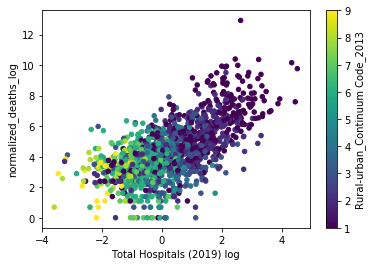

In [40]:
fig, ax = plt.subplots()
cum_deaths.plot.scatter(x='Total Hospitals (2019) log', y='normalized_deaths_log',c='Rural-urban_Continuum Code_2013',colormap='viridis', ax=ax)

In [15]:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(spearmanr(df[r], df[c])[1], 4)
    return pvalues

In [20]:
calculate_pvalues(cum_deaths[['normalized_deaths', 'ICU Beds', 'Total Hospitals (2019)', 'Total_age65plus']])

,normalized_deaths,ICU Beds,Total Hospitals (2019),Total_age65plus
normalized_deaths,0,0,0,0
ICU Beds,0,0,0,0
Total Hospitals (2019),0,0,0,0
Total_age65plus,0,0,0,0


In [44]:
spearmanr(cum_deaths['normalized_deaths'], cum_deaths['Total Hospitals (2019)']).correlation

0.6153708110314977

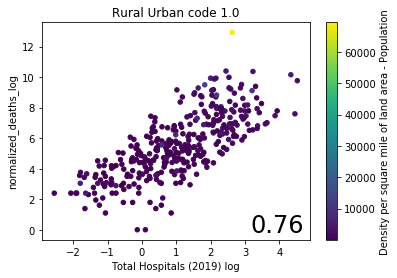

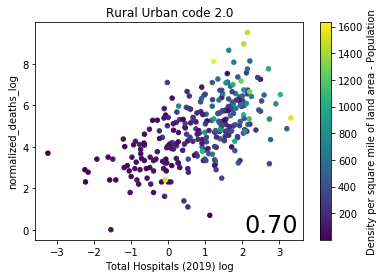

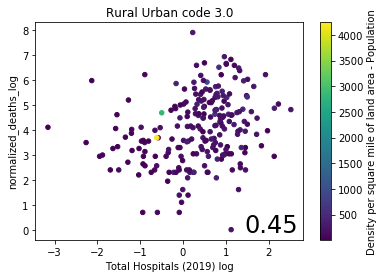

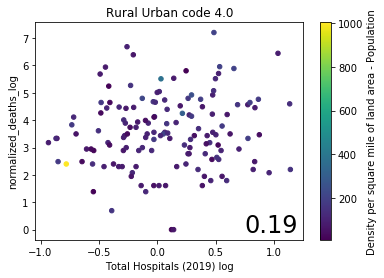

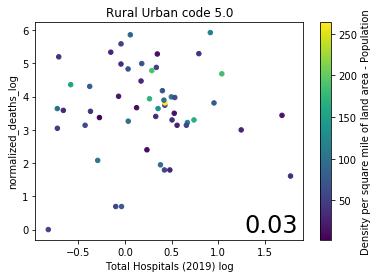

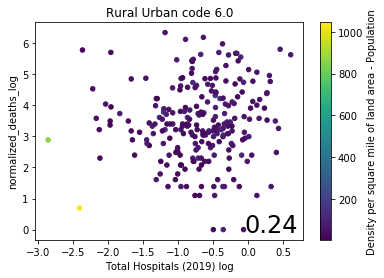

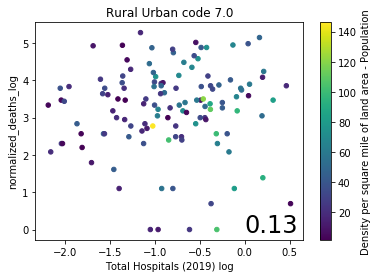

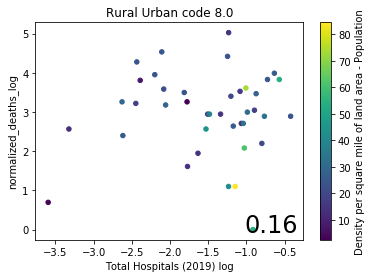

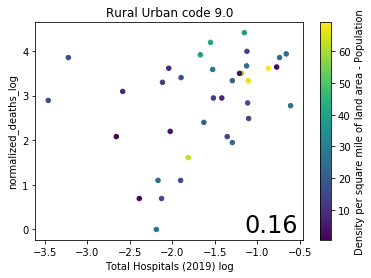

In [45]:
for i in np.unique(cum_deaths['Rural-urban_Continuum Code_2013']):
    temp = cum_deaths[cum_deaths['Rural-urban_Continuum Code_2013'] == i]

    temp['normalized_deaths'] = temp.apply(
    lambda row: normalize(row, {
            'POP_ESTIMATE_2018' : -1,
            'Density per square mile of land area - Population': -1,
            'Rural-urban_Continuum Code_2013': 0,
            'Total_age65plus': 0,
        }), axis=1
    )

    temp[['normalized_deaths_log', 'Total Hospitals (2019) log']] = temp[['normalized_deaths', 'Total Hospitals (2019)']].transform('log')

    fig, ax = plt.subplots()
    temp.plot.scatter(x='Total Hospitals (2019) log', y='normalized_deaths_log',c='Density per square mile of land area - Population',colormap='viridis', ax=ax)
    ax.set_title(f'Rural Urban code {i}')
    corr = spearmanr(temp['normalized_deaths'], temp['Total Hospitals (2019)']).correlation
    ax.text(0.98,0.01, f'{corr:.2f}',size=24, horizontalalignment='right', verticalalignment='bottom', transform = ax.transAxes)
    